In [98]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
import math
%matplotlib inline

In [99]:
item_path = r'D:\all_programming\wetting-analysis\DataFiles\2dContourDataGrid2.txt'

In [100]:
with open(item_path, 'r') as file:
    x_vals = {}
    y_vals = {}
    for row in file:

        if row.startswith('Frame: '):
            row = row.strip()
            junk, current_frame = row.split(': ')
            current_frame = int(current_frame) 
            x_vals[current_frame] = []
            y_vals[current_frame] = []

        elif row.startswith('{'):
            row = row.strip()
            row = row.replace(', ', 'ß')
            row = row.replace('} {', 'ß')
            row = row.replace('{', '')
            row = row.replace('}', '')
            broken_row = row.split('ß')

            for i in range(len(broken_row)):
                if i % 2 == 0:
                    x_vals[current_frame].append(float(broken_row[i]))
                elif i % 2 == 1:
                    y_vals[current_frame].append(float(broken_row[i]))
            
            x_vals_polished = {}
            for frame in x_vals.keys():
                min_x = min(x_vals[frame])
                x_vals_polished[frame] = []

                for item in x_vals[frame]:
                    x_vals_polished[frame].append(item + abs(min_x))
            x_vals = x_vals_polished

In [101]:
# Define the objective function
def objective(params, X, Y):
    a, b, y_0, C, x_0 = params
    summation = np.sum(np.abs((1/a**2)*X**2 - 2*x_0/a**2*X + (1/b**2)*Y**2 - 2*y_0/b**2*Y - C))
    return summation


In [102]:
# Define the implicit equation function
def implicit_eq(X, Y, a, b, y_0, C, x_0):
    return (X**2 / a**2) - (2 * x_0 * X / a**2) + (Y**2 / b**2) - (2 * y_0 * Y / b**2) - C

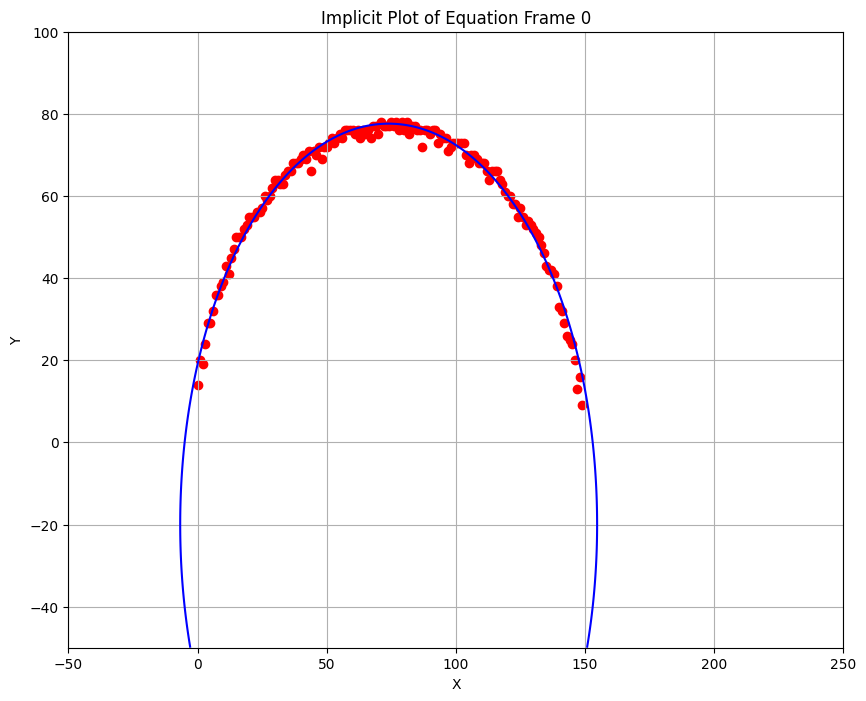

Optimal parameters: a=82.66482246013118, b=99.99841952027316, y_0=-20.0, C=0.11218246621381105, x_0=73.96905334400606
Angle: 80.17832966243841


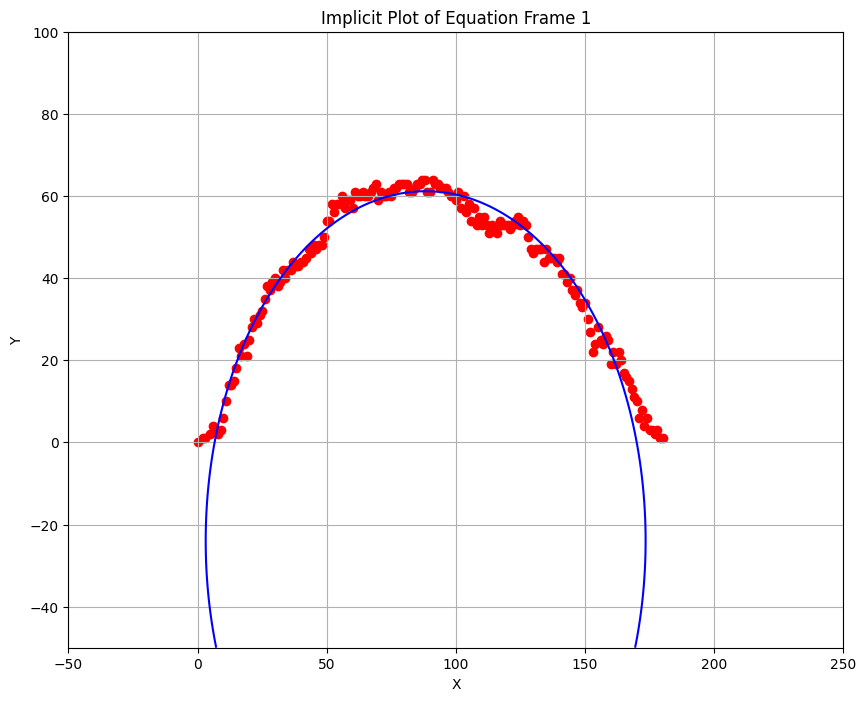

Optimal parameters: a=100.0, b=100.0, y_0=-23.978716481910883, C=-0.11206977796457966, x_0=88.28976620786075
Angle: 73.6681613205994


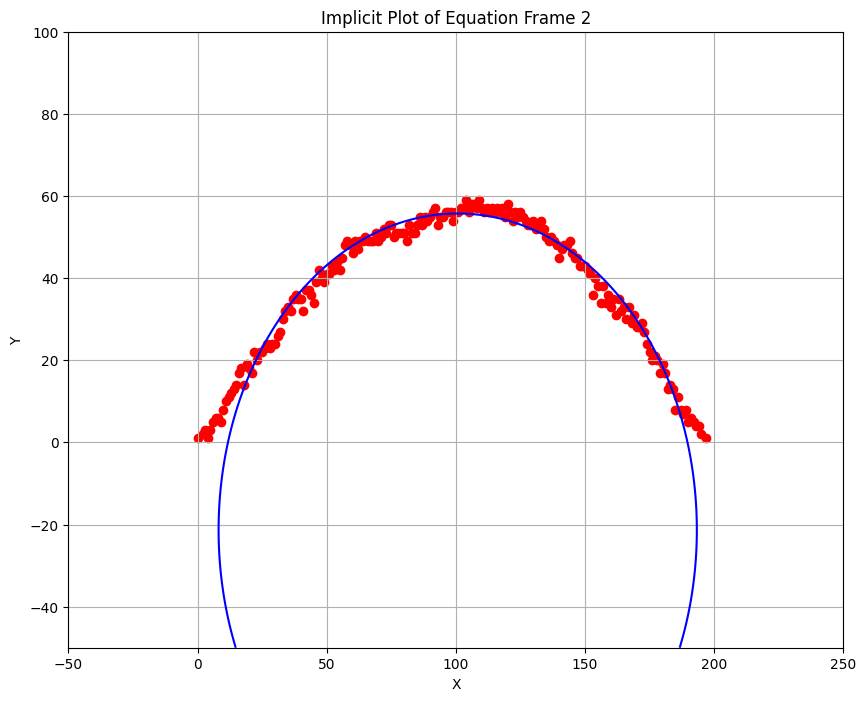

Optimal parameters: a=100.0, b=83.26540426888563, y_0=-21.338881087424305, C=-0.22296392938161624, x_0=100.70147940714567
Angle: 70.85280044282048


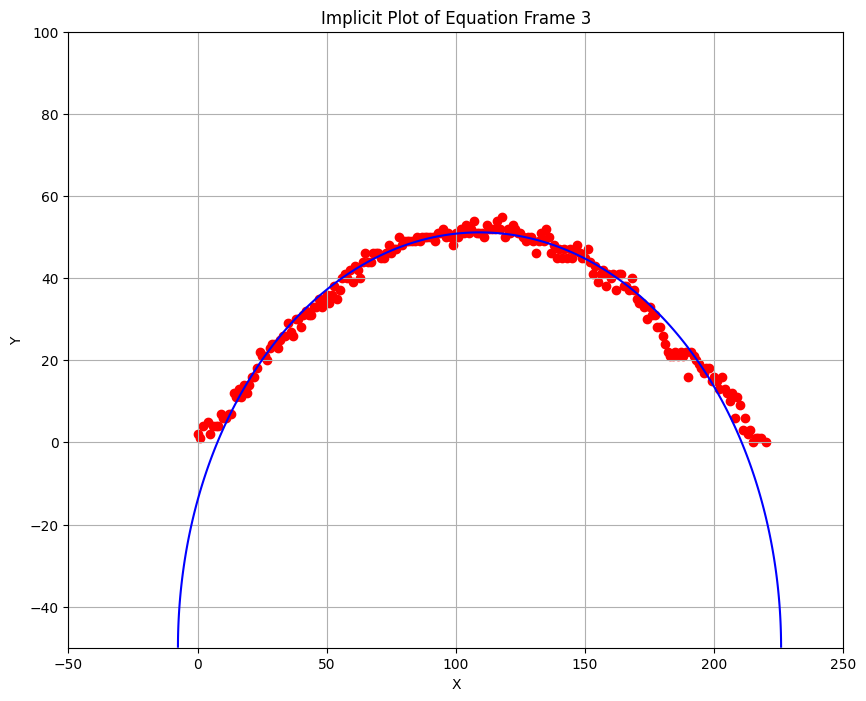

Optimal parameters: a=100.0, b=86.63753213482659, y_0=-50.0, C=-0.16150071476345332, x_0=109.14259954253075
Angle: 56.73380842851235


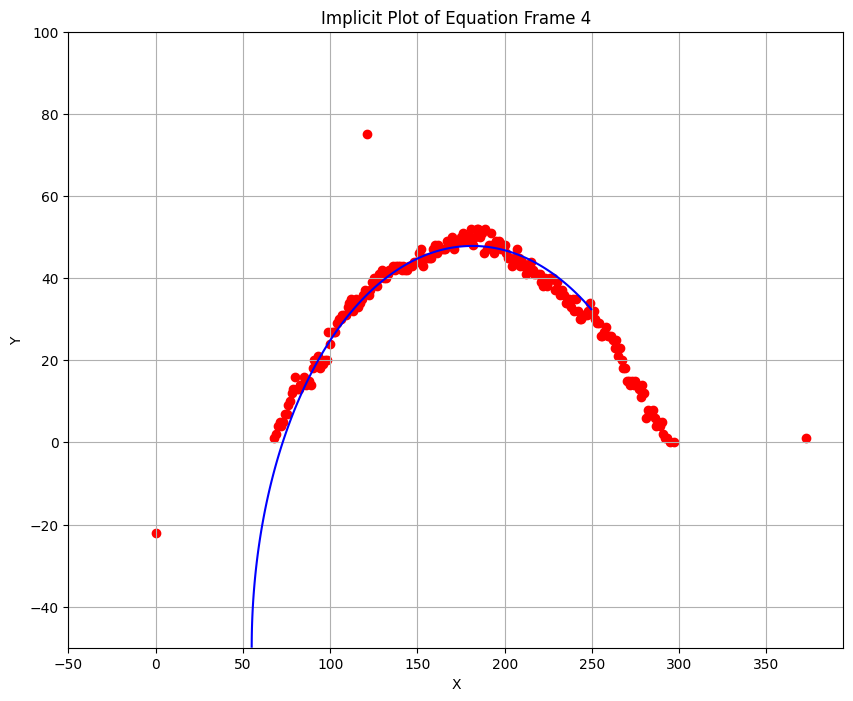

Optimal parameters: a=100.0, b=77.36774581815617, y_0=-50.0, C=-2.112762165745744, x_0=181.5
Angle: 53.24774509394456


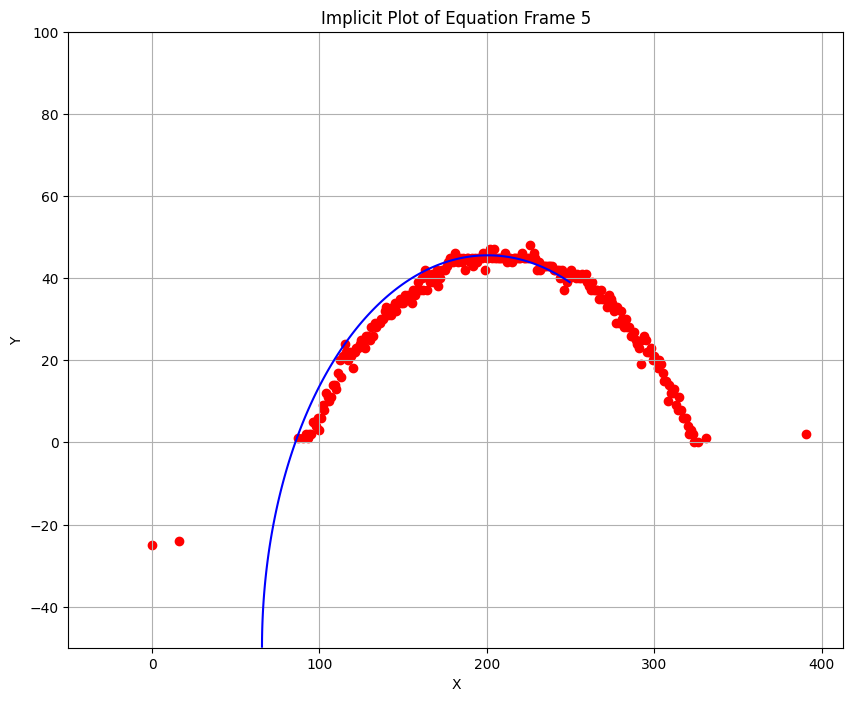

Optimal parameters: a=100.0, b=70.86689071238885, y_0=-50.0, C=-2.699746908596834, x_0=200.5
Angle: 48.09399665802031


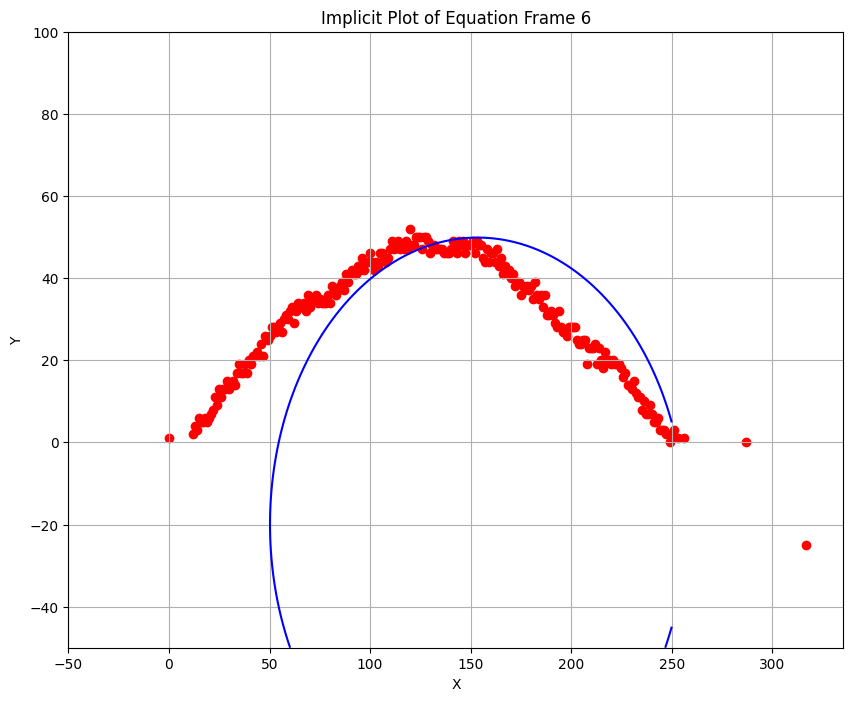

Optimal parameters: a=100.0, b=67.66626890257491, y_0=-20.00005324462395, C=-1.37742614604311, x_0=153.5
Angle: 66.72094879636629


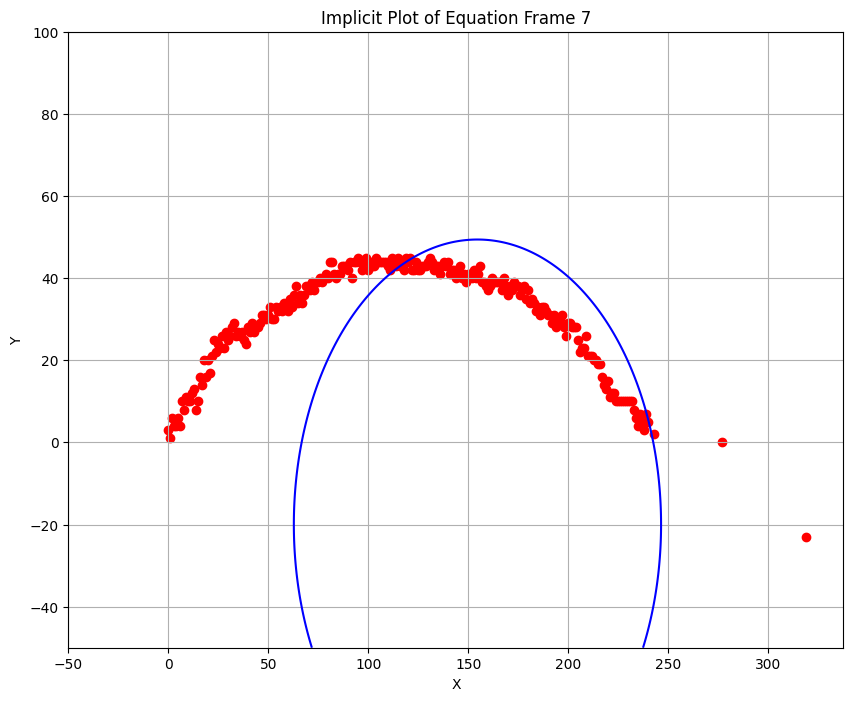

Optimal parameters: a=100.0, b=75.60443884095932, y_0=-20.00032439343002, C=-1.614410838043915, x_0=154.5
Angle: 69.05553567541848


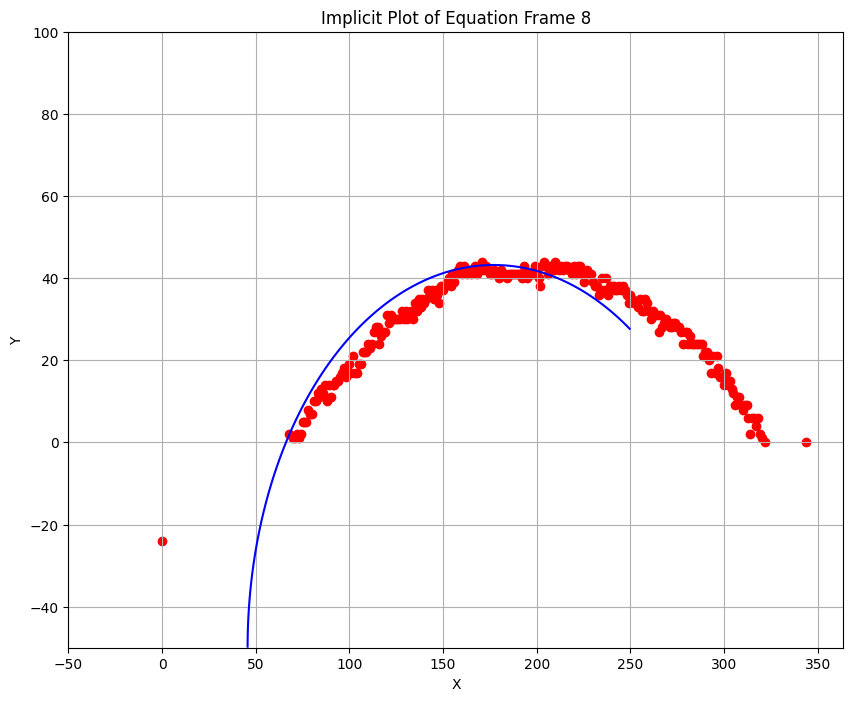

Optimal parameters: a=100.0, b=70.9522168715884, y_0=-50.0, C=-1.9042773218706386, x_0=177.0
Angle: 47.31010303352847


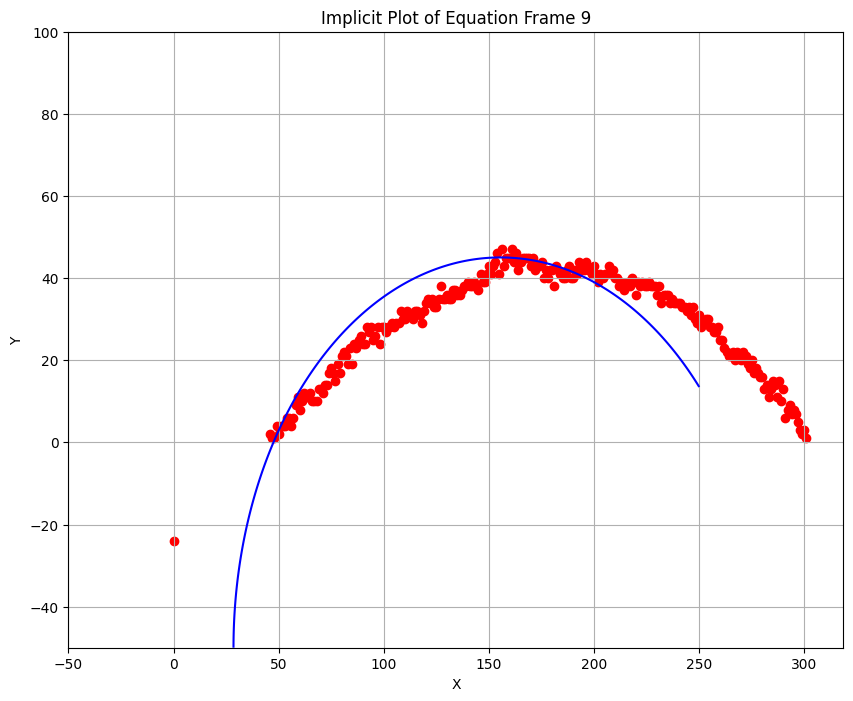

Optimal parameters: a=100.0, b=74.83647467446939, y_0=-50.0, C=-1.2517249963832622, x_0=155.5
Angle: 49.80449745595272


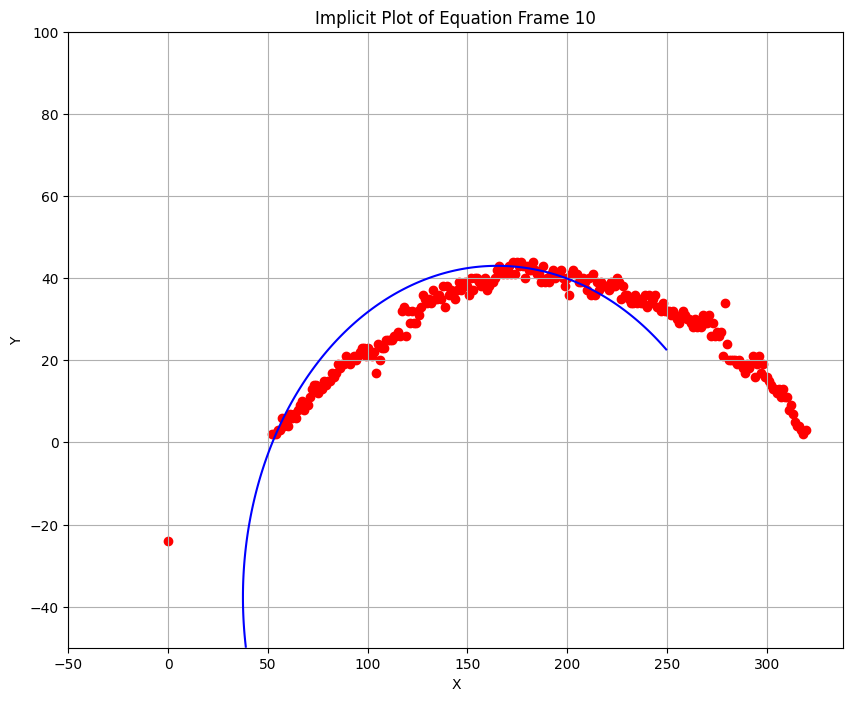

Optimal parameters: a=100.0, b=63.30150005791456, y_0=-37.717905465078225, C=-1.4517505033141054, x_0=165.0
Angle: 49.516301468761135


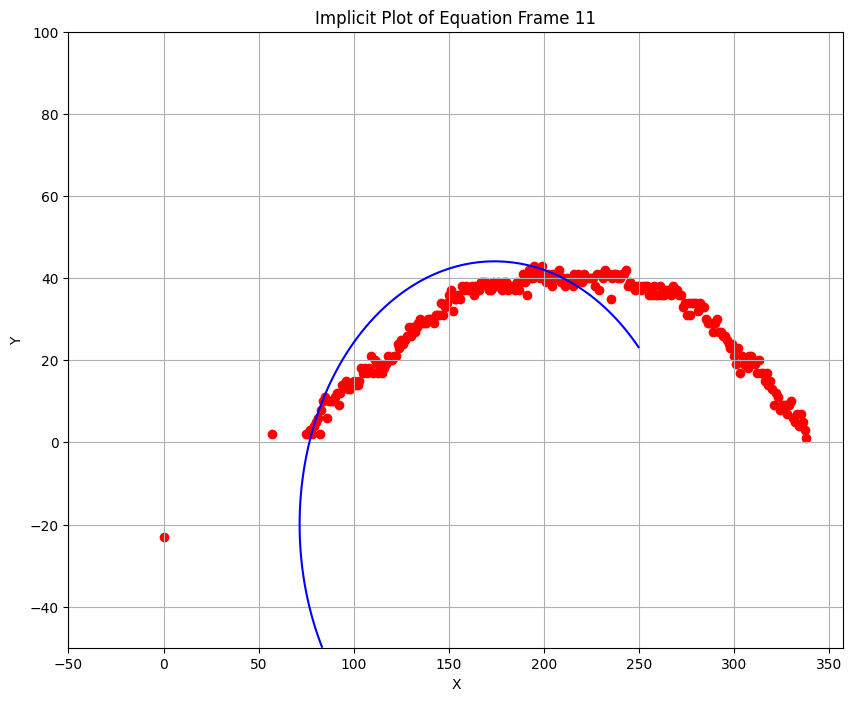

Optimal parameters: a=100.0, b=62.55057930246505, y_0=-20.000107466766444, C=-2.0801166219572, x_0=174.0
Angle: 61.227945286766065


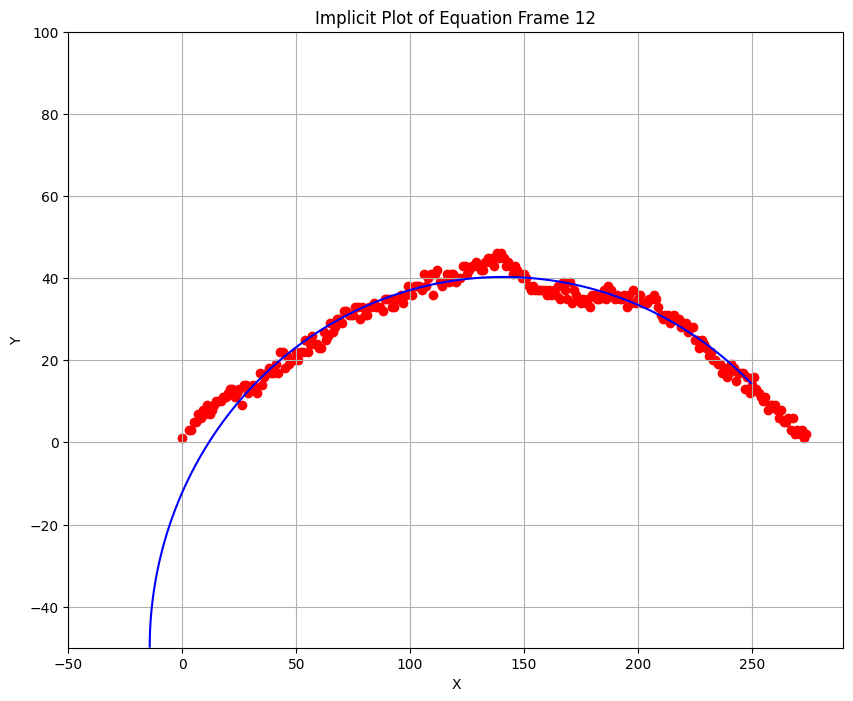

Optimal parameters: a=100.0, b=58.16974604611813, y_0=-50.0, C=-0.31506835049645165, x_0=140.89974944942495
Angle: 41.09299145897856


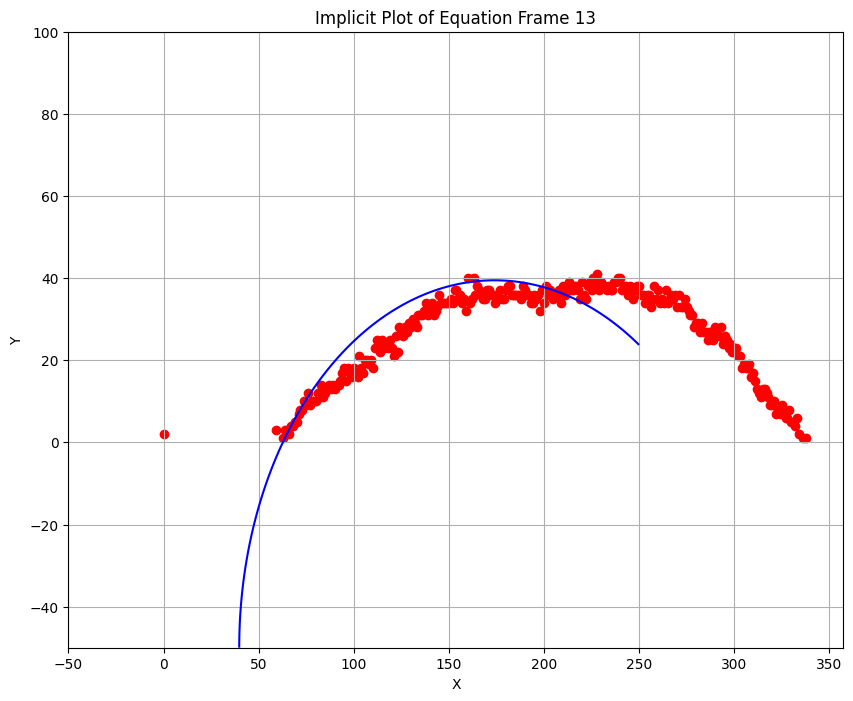

Optimal parameters: a=100.0, b=66.66681601452427, y_0=-50.0, C=-1.7891049259195282, x_0=174.0
Angle: 43.9091925339956


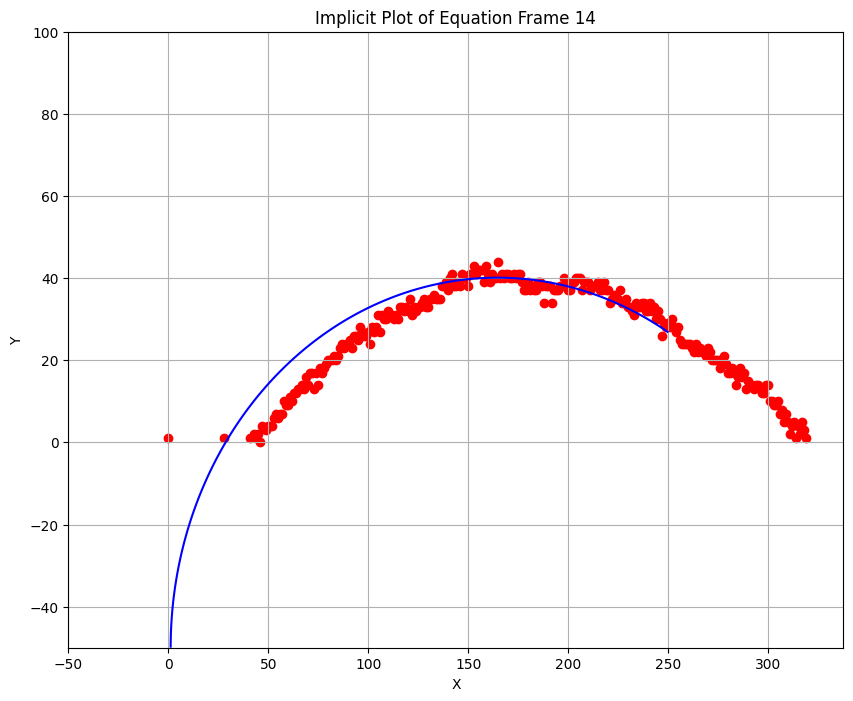

Optimal parameters: a=100.0, b=55.15029260034361, y_0=-49.99999970957224, C=-0.8586878732763993, x_0=164.5
Angle: 39.356140579582934


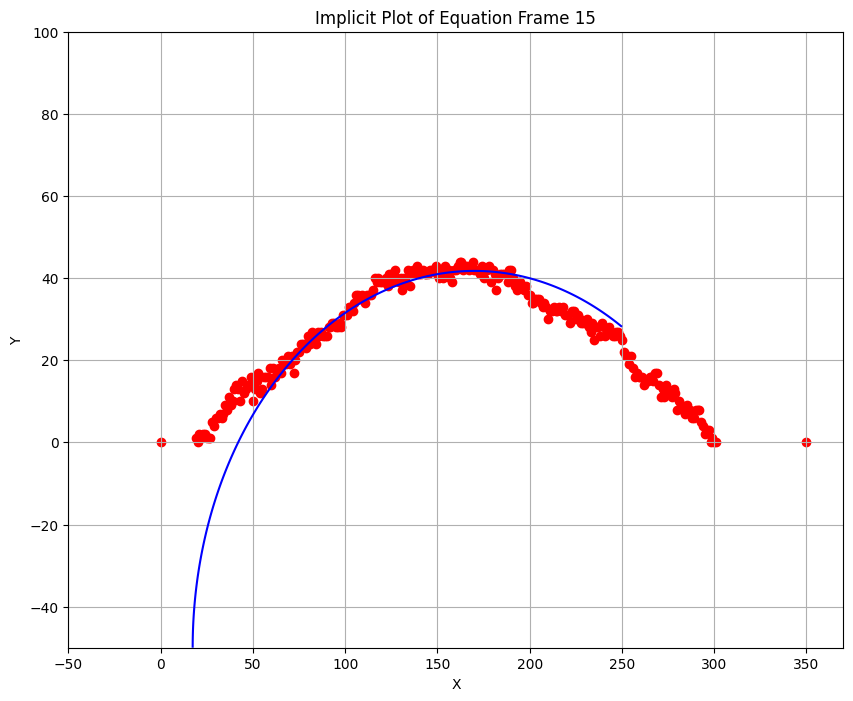

Optimal parameters: a=100.0, b=60.107544663464864, y_0=-50.0, C=-1.251600001887648, x_0=170.0
Angle: 43.114218015796354


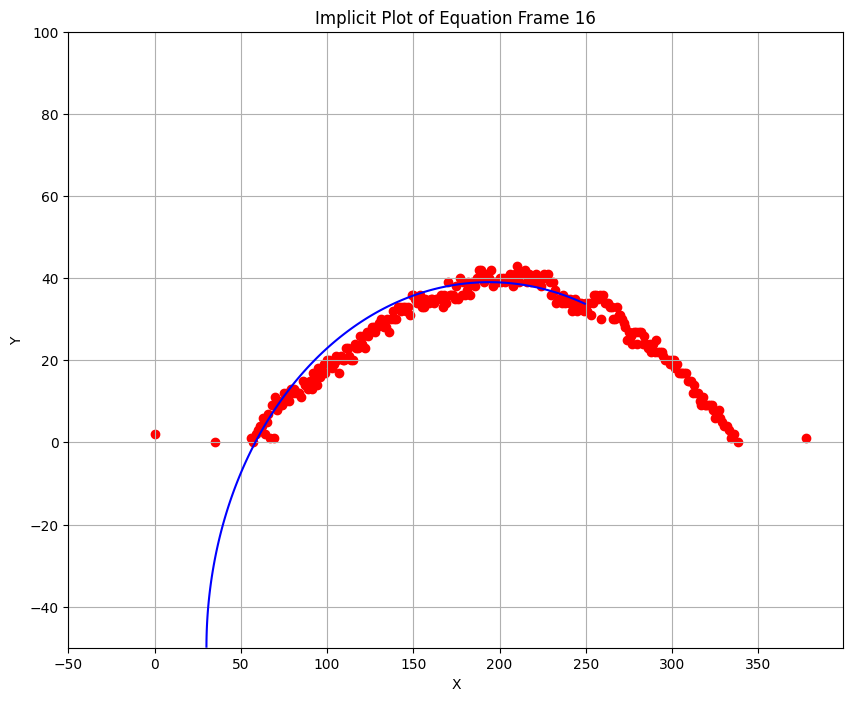

Optimal parameters: a=100.0, b=54.29263074485444, y_0=-50.0, C=-1.923632644349768, x_0=194.0
Angle: 38.181521707162844


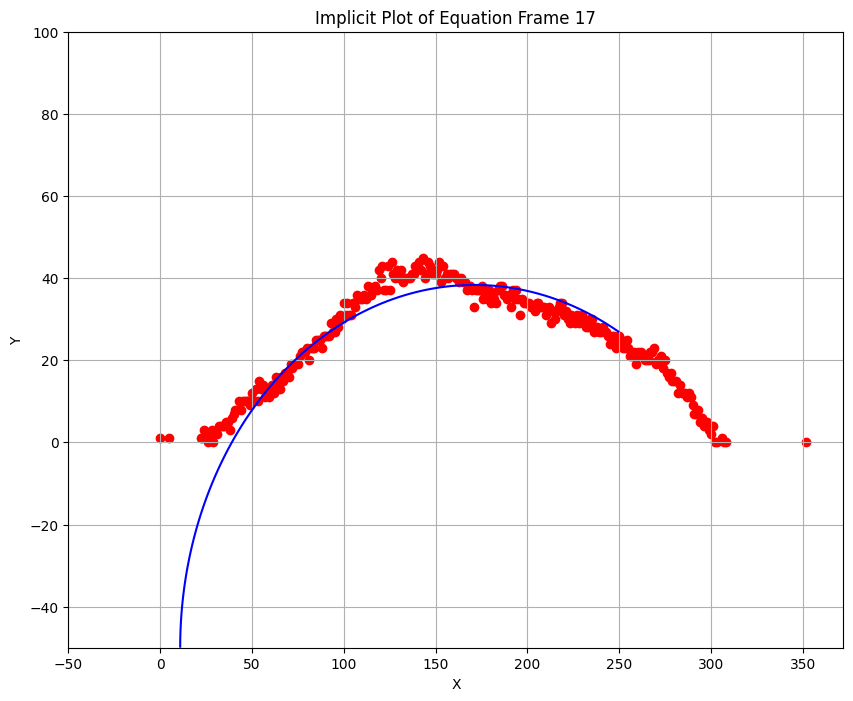

Optimal parameters: a=100.0, b=55.171151466130766, y_0=-50.0, C=-1.181699993406223, x_0=171.0
Angle: 39.08344893102381


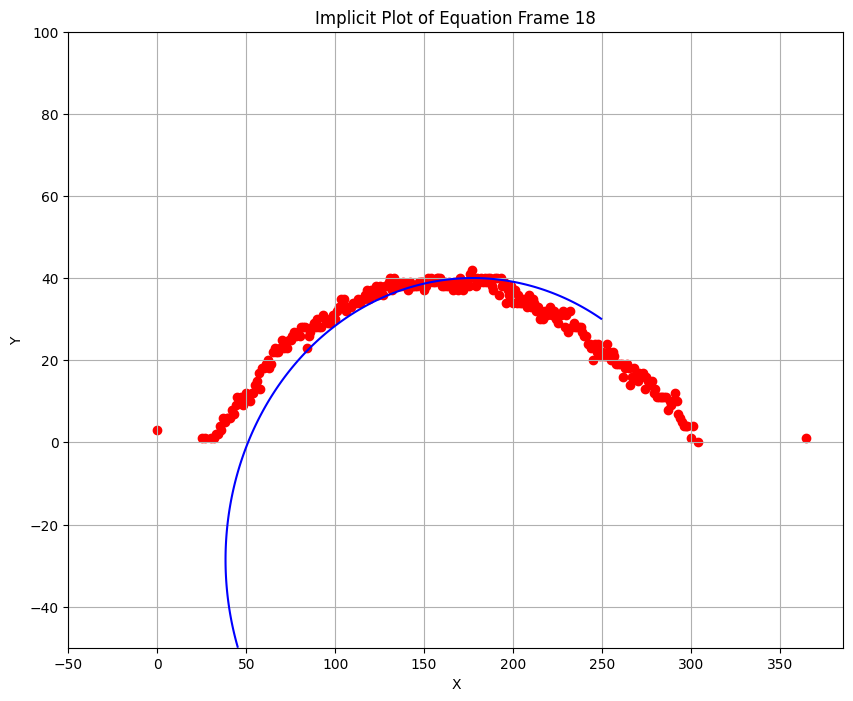

Optimal parameters: a=100.0, b=49.297385453032774, y_0=-28.581150101172106, C=-1.5504074572244566, x_0=177.5
Angle: 47.517703243076916


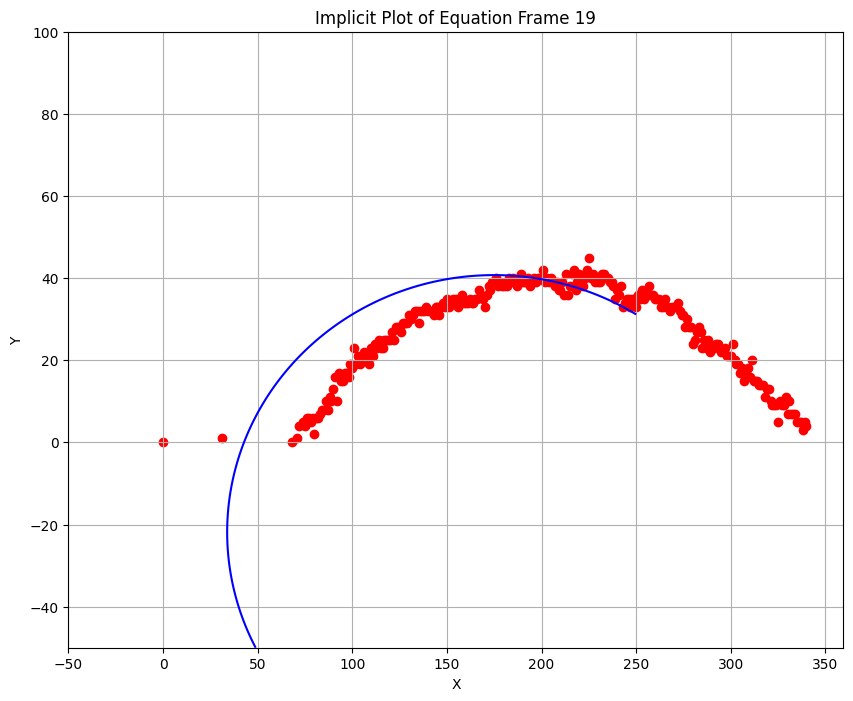

Optimal parameters: a=100.0, b=44.3615235834161, y_0=-21.86421238223242, C=-1.3141187554668428, x_0=175.0
Angle: 49.597830348727435


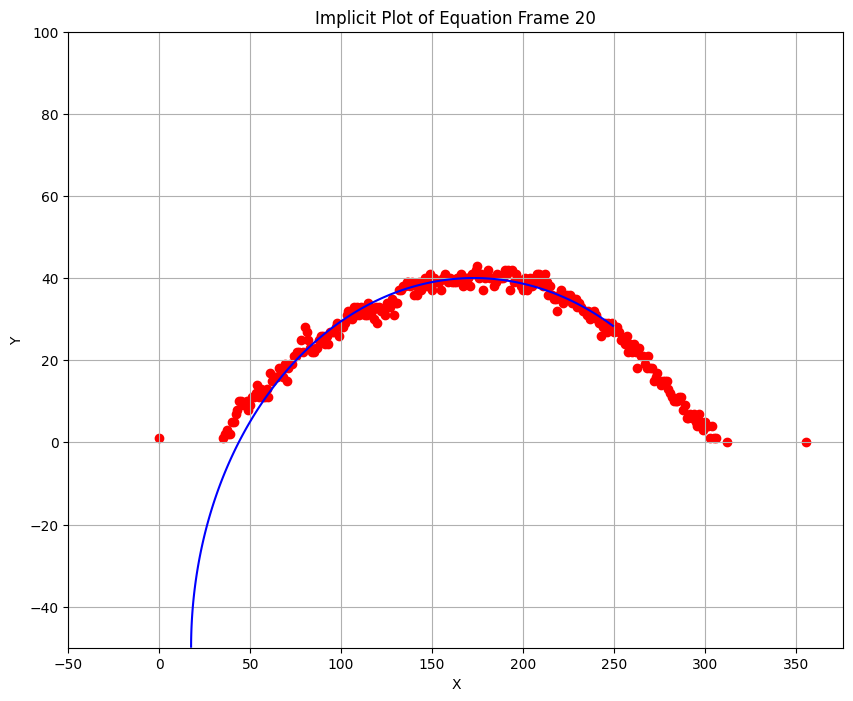

Optimal parameters: a=100.0, b=57.884601962985194, y_0=-50.0, C=-1.3204804508110533, x_0=173.0
Angle: 41.265339591813586


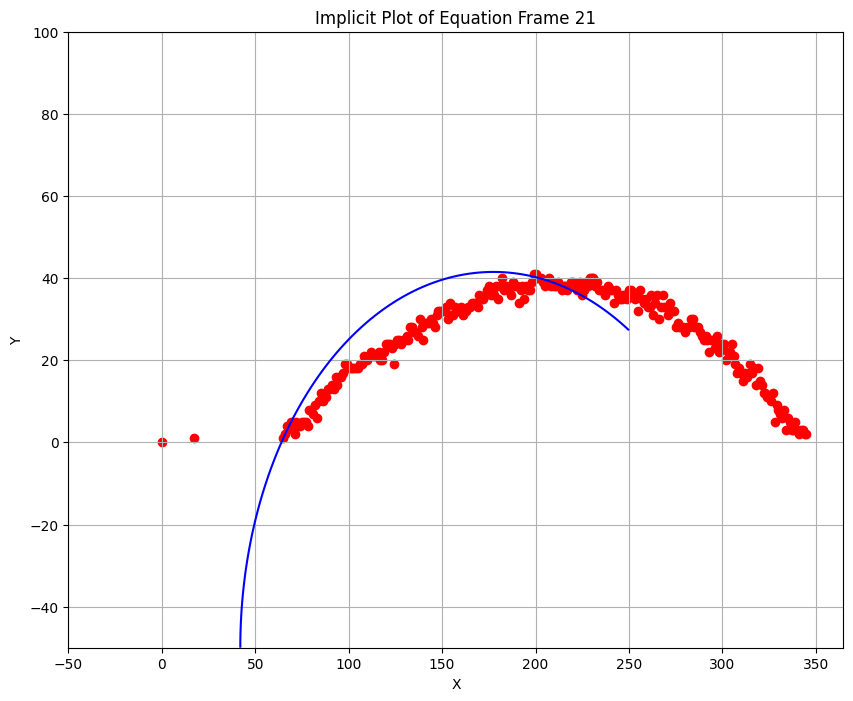

Optimal parameters: a=100.0, b=67.53011308691929, y_0=-50.0, C=-1.8626666083109489, x_0=177.5
Angle: 45.22261509269019


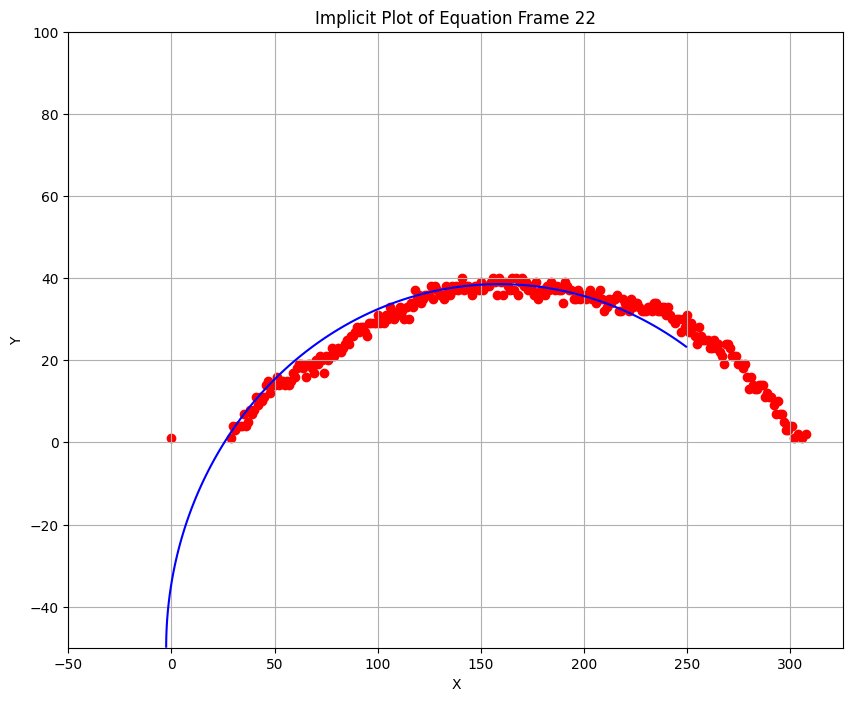

Optimal parameters: a=100.0, b=54.795929386118054, y_0=-49.999999979749795, C=-0.749893001039491, x_0=159.0
Angle: 38.476418172867334


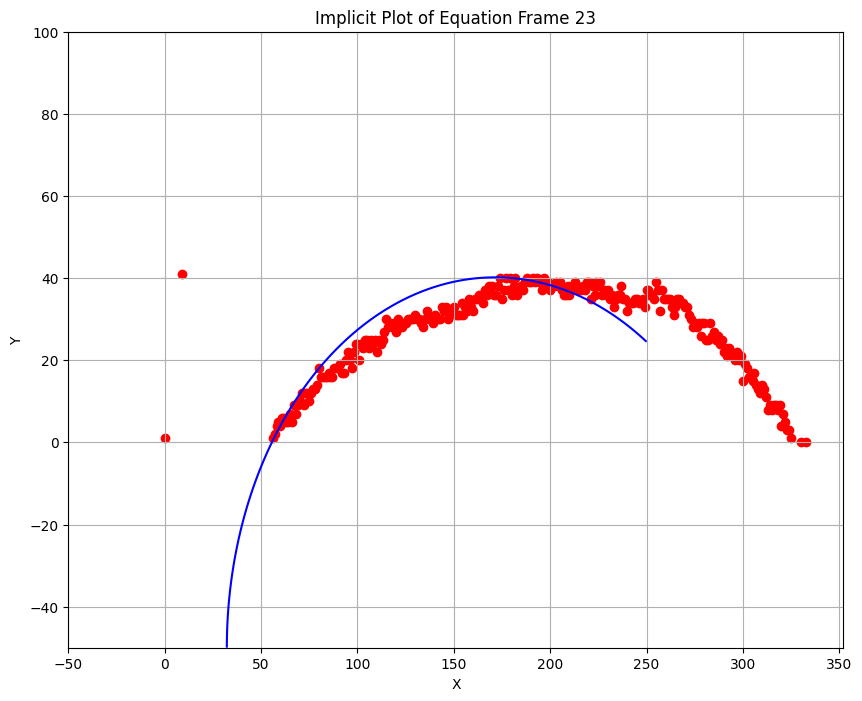

Optimal parameters: a=100.0, b=64.74889859430279, y_0=-50.0, C=-1.597371077872204, x_0=171.5
Angle: 43.55415909860302


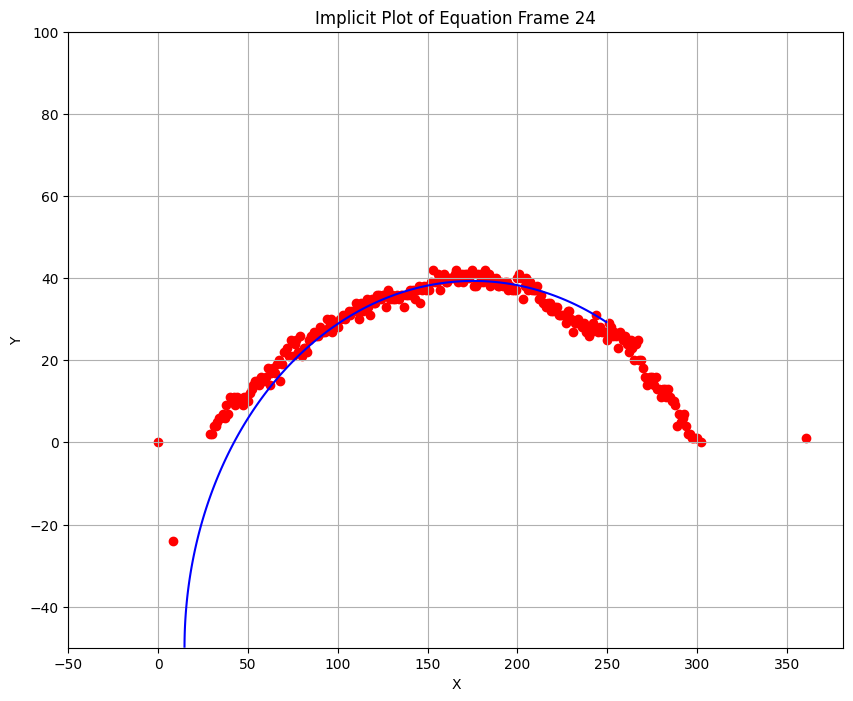

Optimal parameters: a=100.0, b=55.52678897900828, y_0=-50.0, C=-1.3035831005936427, x_0=175.5
Angle: 39.73490511586865


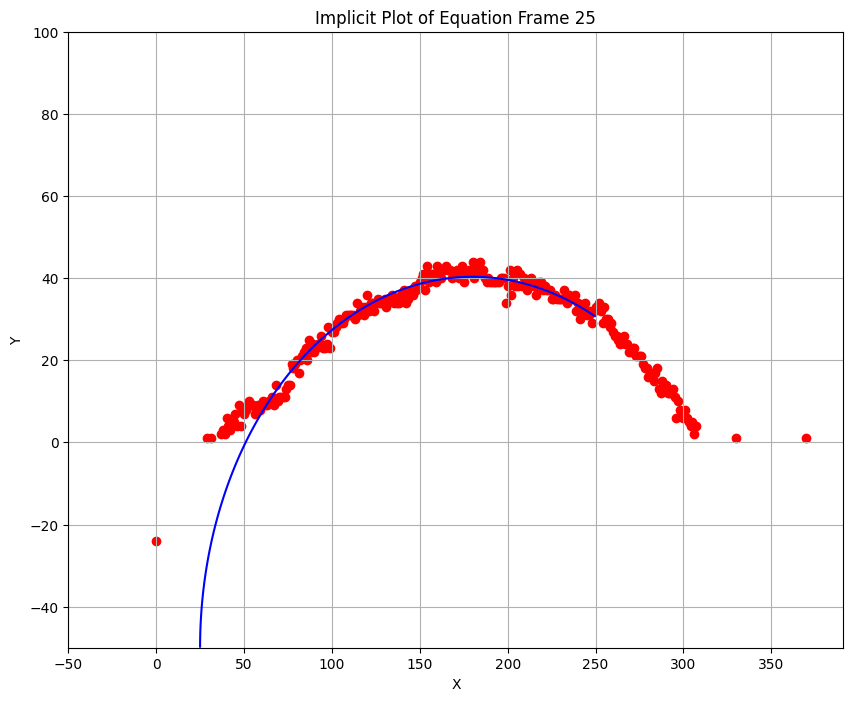

Optimal parameters: a=100.0, b=58.243915664982666, y_0=-50.0, C=-1.5720814243161971, x_0=180.0
Angle: 41.63712210949918


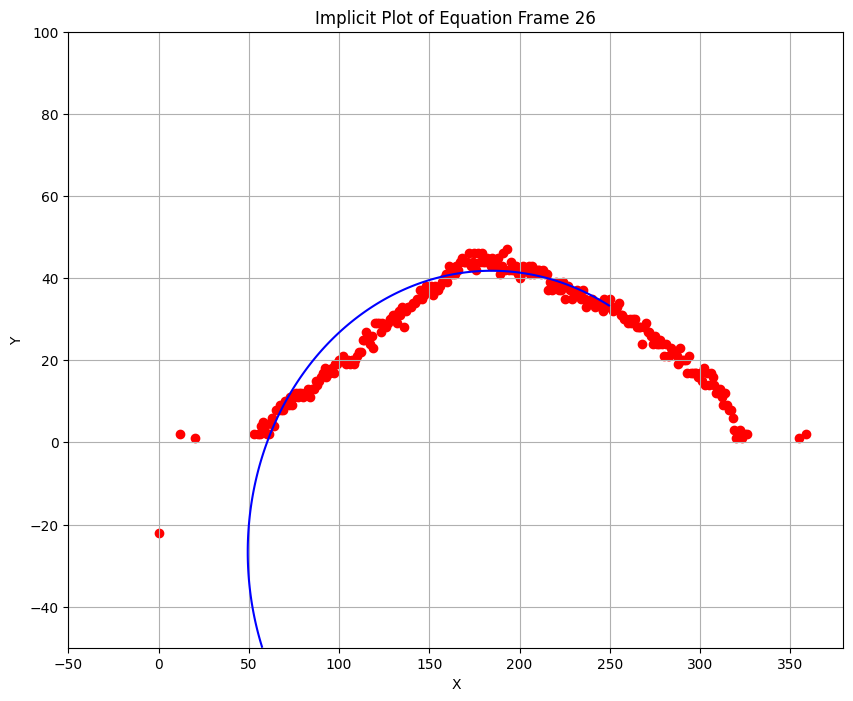

Optimal parameters: a=100.0, b=50.688497436065695, y_0=-26.697889391630177, C=-1.8556344041709447, x_0=184.5
Angle: 49.55332193004596


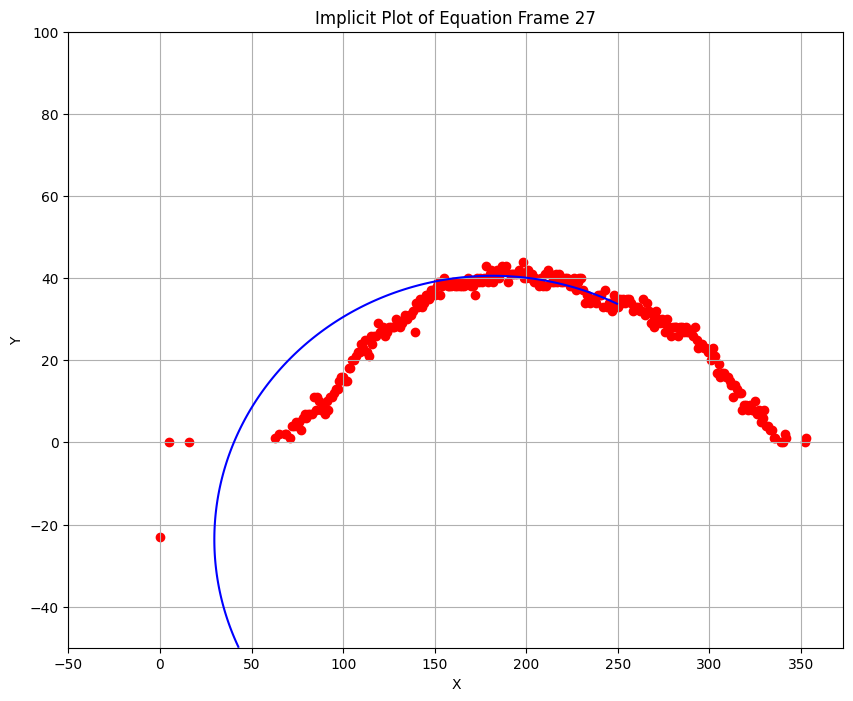

Optimal parameters: a=100.0, b=42.31101850514707, y_0=-23.66825239617178, C=-1.3022119919585582, x_0=181.5
Angle: 46.5675834471635


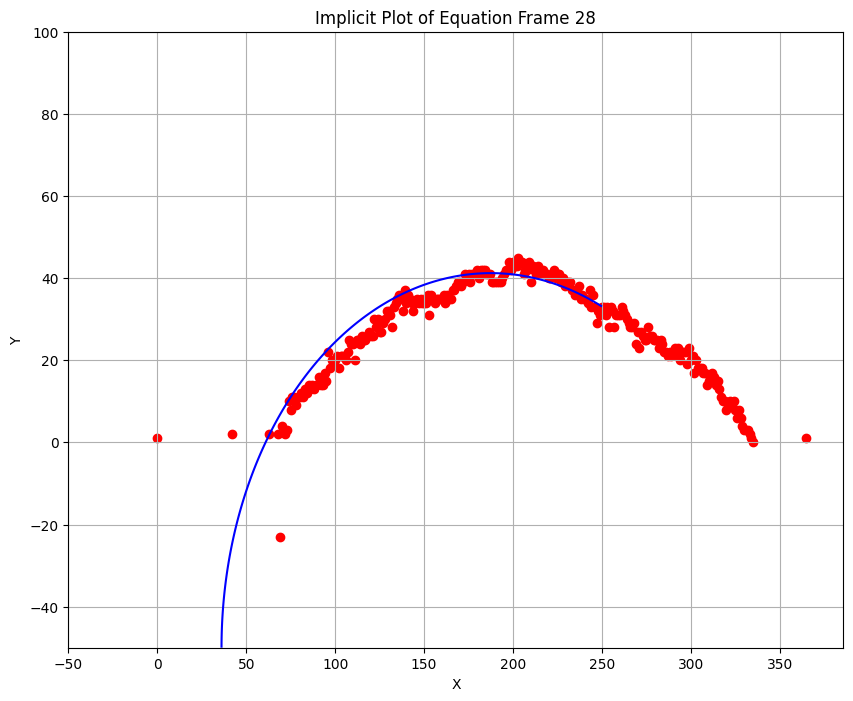

Optimal parameters: a=100.0, b=60.24519993180559, y_0=-50.0, C=-1.9119318470600997, x_0=187.5
Angle: 42.015771812118786


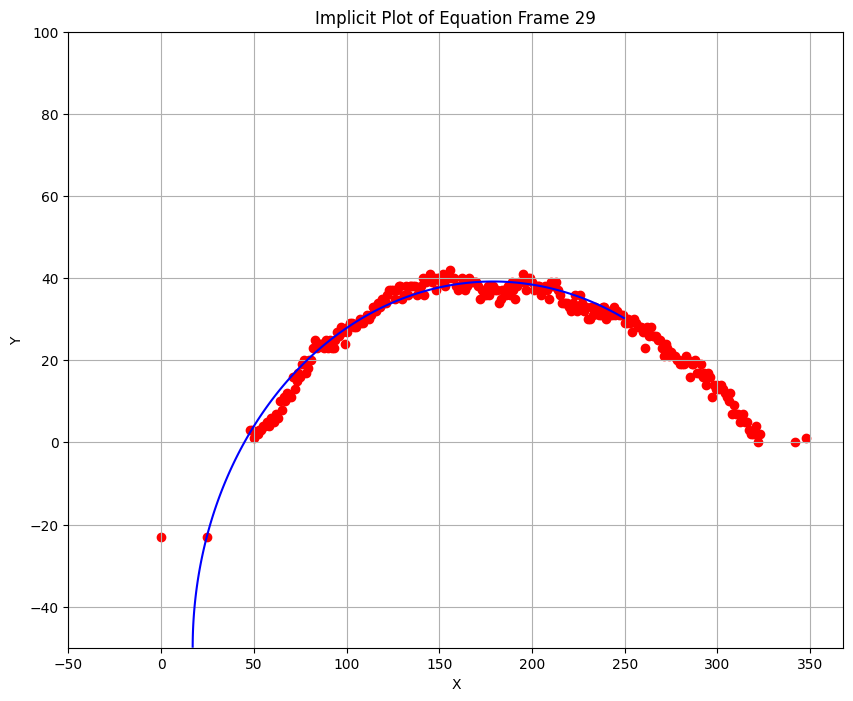

Optimal parameters: a=100.0, b=55.05099801183433, y_0=-50.0, C=-1.4049091616963731, x_0=179.0
Angle: 38.74406407928889


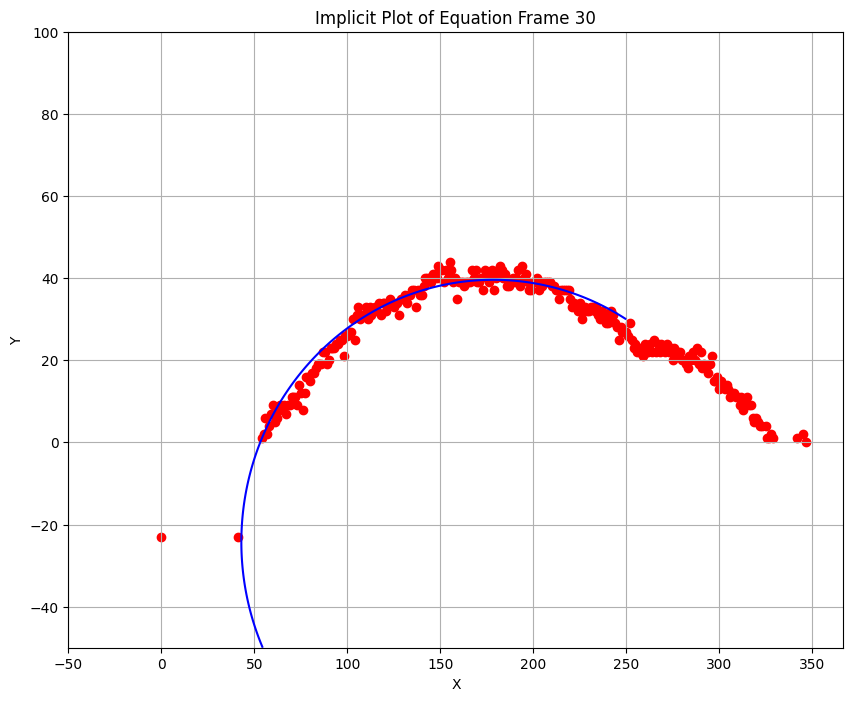

Optimal parameters: a=100.0, b=47.1314207130873, y_0=-24.2547501702816, C=-1.6156196308220918, x_0=178.5
Angle: 48.4258401526802


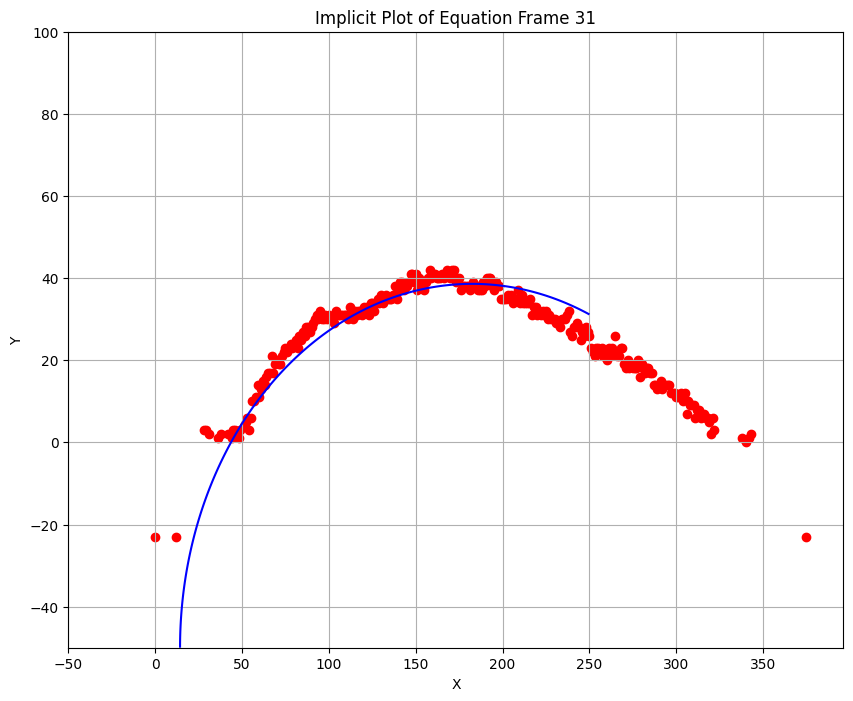

Optimal parameters: a=100.0, b=52.67184769208946, y_0=-50.0, C=-1.4020002900678228, x_0=182.5
Angle: 37.91631941916574


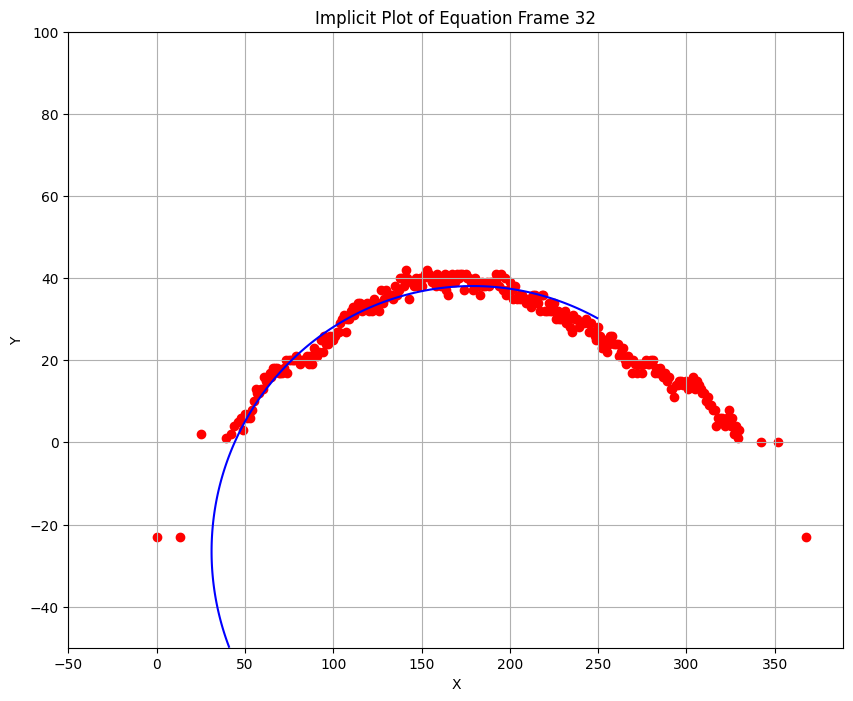

Optimal parameters: a=100.0, b=43.69049520206908, y_0=-26.557950027317837, C=-1.3854642165944961, x_0=179.0
Angle: 44.43782515534158


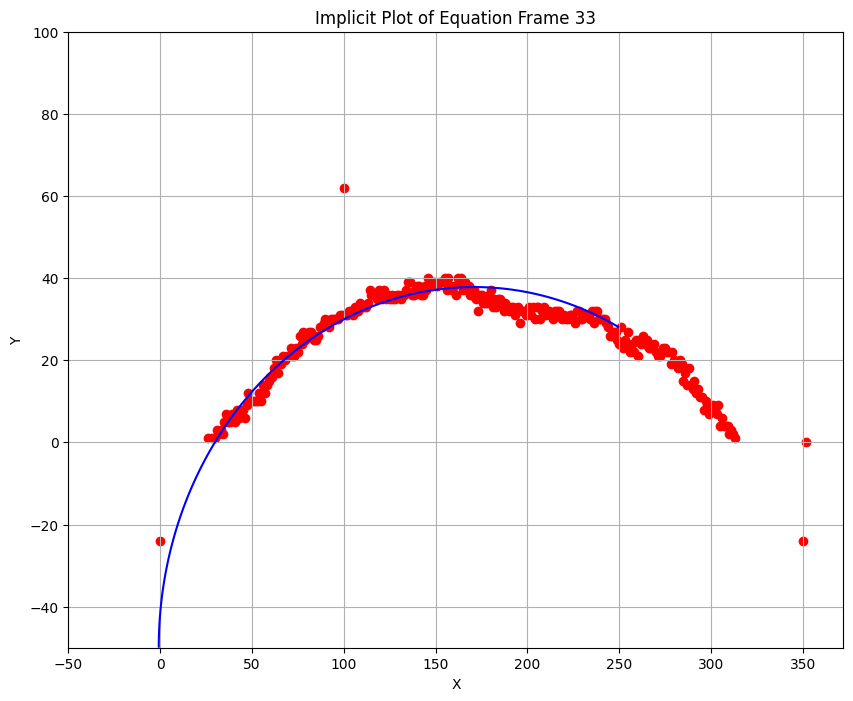

Optimal parameters: a=100.0, b=51.12451895415171, y_0=-50.0, C=-0.9294362141739322, x_0=171.0
Angle: 36.633972579591884


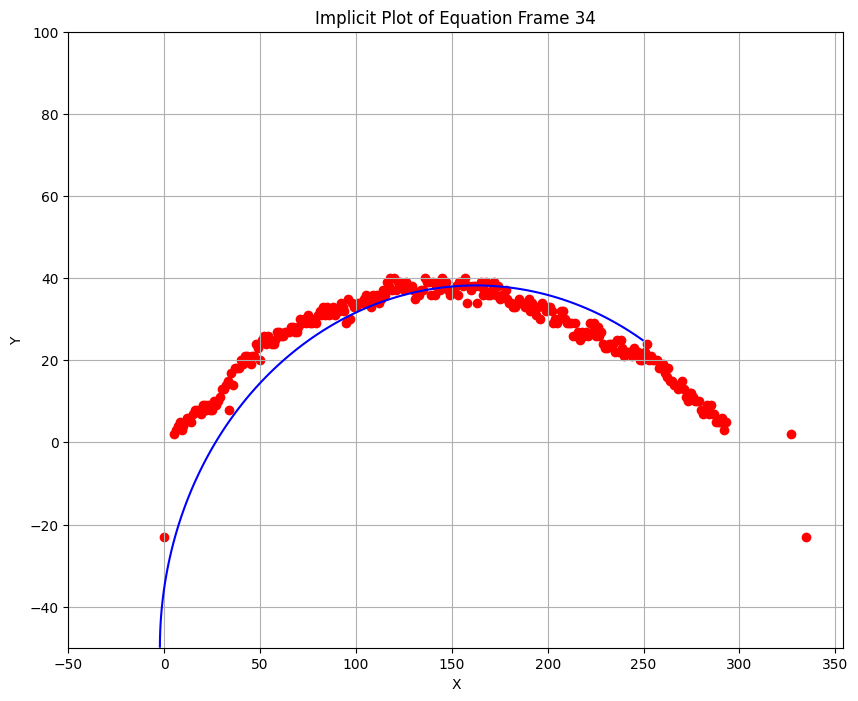

Optimal parameters: a=100.0, b=53.5357534070277, y_0=-50.0, C=-0.7977202789131116, x_0=162.5
Angle: 38.0818447903051


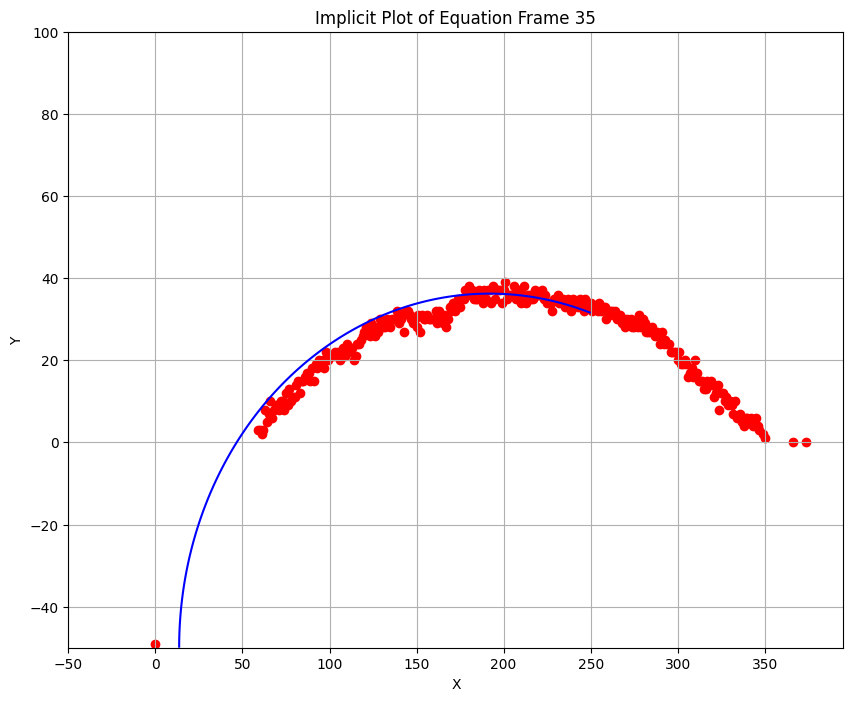

Optimal parameters: a=100.0, b=48.33957159189894, y_0=-50.0, C=-1.5742500289859733, x_0=192.0
Angle: 33.876744113206286


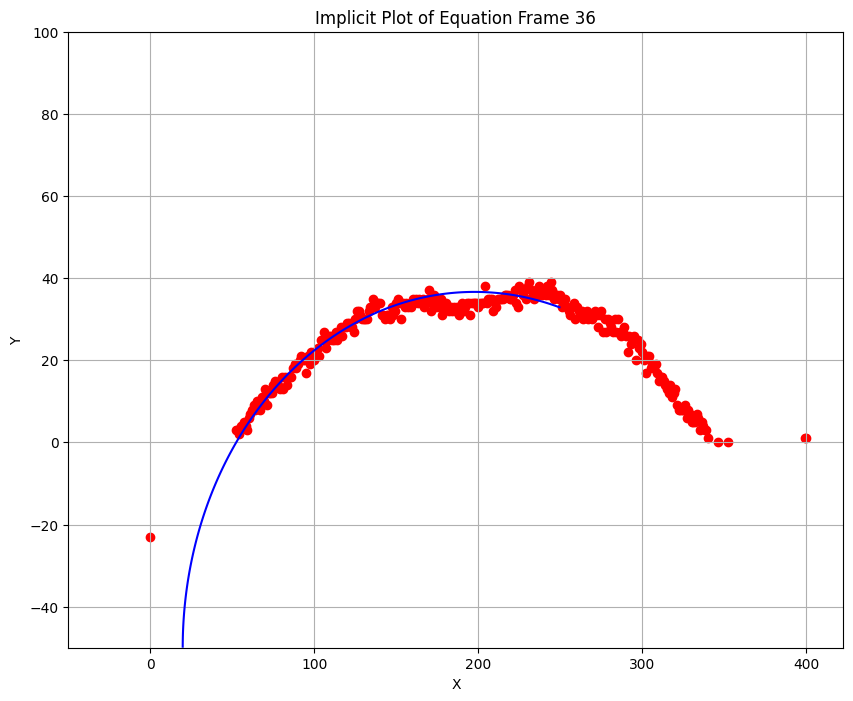

Optimal parameters: a=100.0, b=48.69520310782481, y_0=-50.0, C=-1.7937996639855773, x_0=197.62244206988228
Angle: 34.72712464313938


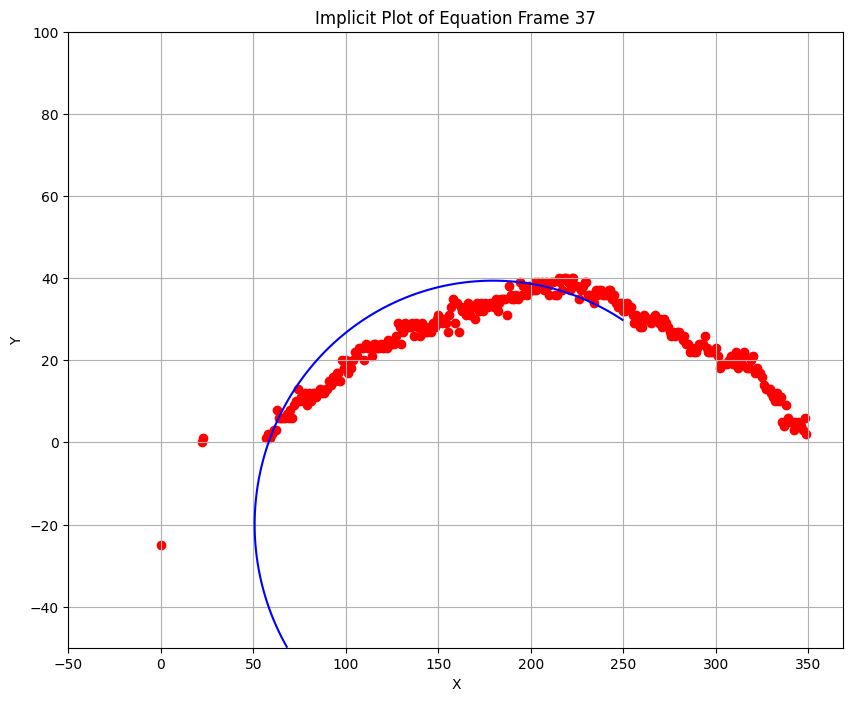

Optimal parameters: a=100.0, b=46.093679893544895, y_0=-20.00197247820779, C=-1.7507908759930206, x_0=179.5
Angle: 51.596466089413646


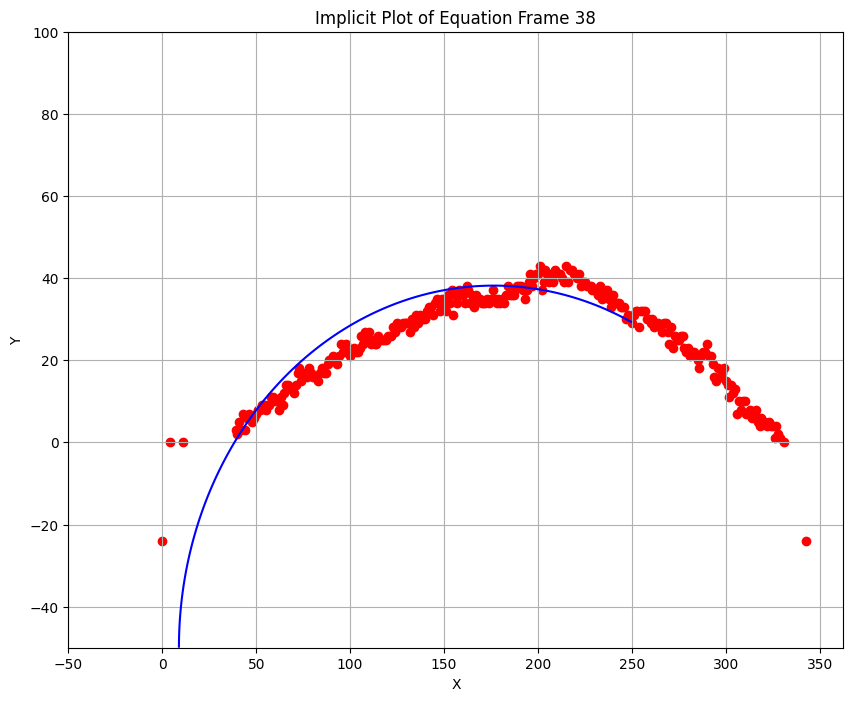

Optimal parameters: a=100.0, b=52.59373058329053, y_0=-50.0, C=-1.208273482081284, x_0=176.5
Angle: 37.086687753230684


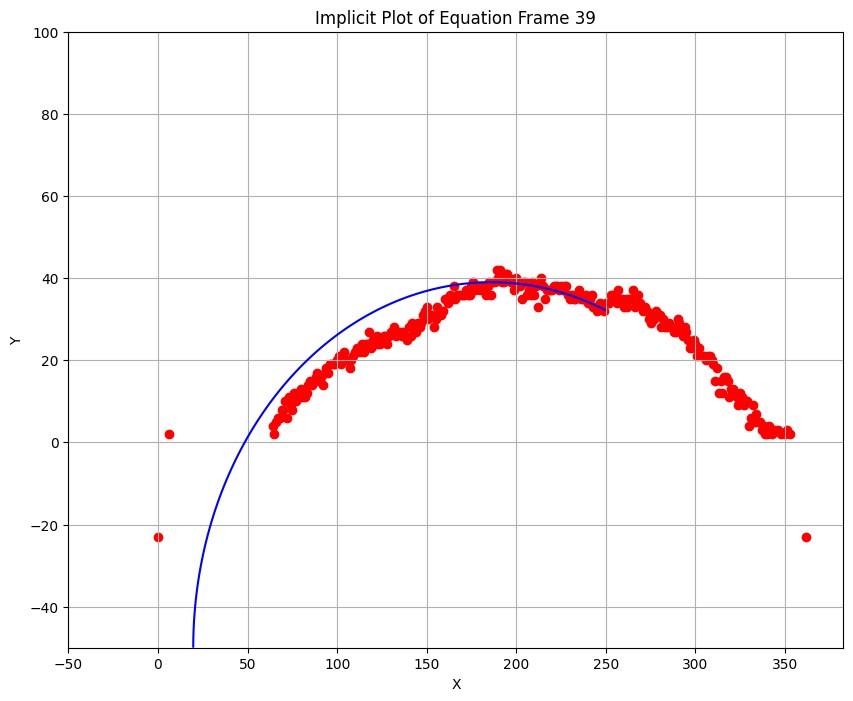

Optimal parameters: a=100.0, b=53.51375991849861, y_0=-50.0, C=-1.5665093218609065, x_0=186.0
Angle: 37.86535853334576


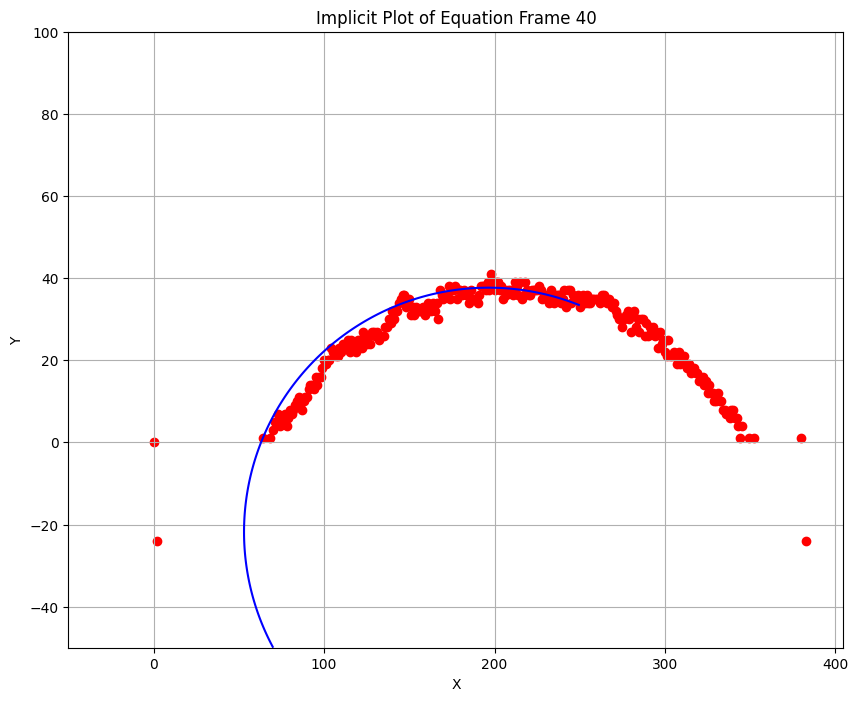

Optimal parameters: a=100.0, b=41.46336893331453, y_0=-21.81583798715487, C=-2.079639443258011, x_0=196.5
Angle: 45.911911094631684


In [103]:
frame_list = []
angle_list = []
x_0_list = []
ellipse_fit_error = 0

for frame in range(len(x_vals.keys())):
    
    X_data = np.array(x_vals[frame])  # X values
    Y_data = np.array(y_vals[frame])  # Y values
    
    x_0 = max(X_data) / 2  # Generally true statement 
    x_0_list.append(x_0)
    x_0_pm = 5

    # Initial guess for the parameters [a, b, y_0, C, x_0]
    initial_guess = [0.4, 0.5, -11.1, 10, x_0]

    # Define bounds for the parameters: (a, b, y_0, C, x_0)
    a_B = (0.1, 100)
    b_B = (0.1, 100)
    y_0_B = (-50, -20)
    C_B = (-100, 100)
    x_0_B = (x_0 - x_0_pm, x_0 + x_0_pm)
    
    bounds = [a_B, b_B, y_0_B, C_B, x_0_B] 

    # Perform the optimization
    result = minimize(objective, initial_guess, args=(X_data, Y_data), method='L-BFGS-B', bounds=bounds)

    # Extract the optimal parameters
    a_opt, b_opt, y_0_opt, C_opt, x_0_opt = result.x

    # Create a grid of points
    x = np.linspace(-50, 250, 400)
    y = np.linspace(-50, 100, 400)
    X, Y = np.meshgrid(x, y)
    Z = implicit_eq(X, Y, a_opt, b_opt, y_0_opt, C_opt, x_0_opt)

    # Plot the contour where Z = 0
    plt.figure(figsize=(10, 8))
    contour = plt.contour(X, Y, Z, levels=[0], colors='blue')
    plt.title(f'Implicit Plot of Equation Frame {frame}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.scatter(X_data, Y_data, color='red')  # Scatter plot of your data points

    subdirectory = r'C:\Users\jeffs\Downloads\SZvsWorkspaceUpper\SZvsWorkspace\Research\Project2WettingAngle\ProgramOutputs\fitting_methods'
    plot_path = os.path.join(subdirectory, f'best_fit_ellipse{frame}.png')
    #plt.savefig(plot_path)

    plt.show()

    for i in range(len(x_vals[frame])):
        ellipse_fit_error += np.abs((1/(a_opt**2))*X_data[i]**2 - (2*x_0_opt/(a_opt**2))*X_data[i] + (1/(b_opt**2))*Y_data[i]**2 - (2*y_0_opt)/(b_opt**2)*Y_data[i] - C_opt)

    # Angle calculation
    x_a = x_0_opt + math.sqrt(x_0**2 + C_opt * a_opt**2)
    dydx_x_a = b_opt**2*(x_0-x_a)/(a_opt**2*(-y_0_opt))
    theta = abs(math.atan(dydx_x_a)) * 180 / math.pi

    # Creating x & y datas
    frame_list.append(frame)
    angle_list.append(theta)

    print(f"Optimal parameters: a={a_opt}, b={b_opt}, y_0={y_0_opt}, C={C_opt}, x_0={x_0_opt}")
    print(f'Angle: {theta}')

In [104]:
junk, useful = item_path.split('DataFiles')
useful = useful.replace('\\', '')

In [105]:
average_theta = sum(angle_list) / len(angle_list)
print(f'File Name: {useful}')
print(f'Average CA: {round(average_theta,2)}°')

File Name: 2dContourDataGrid1.txt
Average CA: 47.36°
